# Diagnostic pybobqa

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import time
import pylab as pl
from IPython import display
from cpymad.madx import Madx
from pybt.tools.parsers import read_twiss_file
import numpy as np

In [10]:
def gaussian_function(x, a, I, mu, sig):
    return a + I / np.sqrt(2 * np.pi * sig ** 2) * np.exp(-(x - mu) ** 2 / 2. / sig ** 2)

def do_gaussian_fit(x,y):
    mu = np.average(x, weights=np.abs(y - np.min(y)))
    sigma = np.sqrt(np.average(x**2, weights=np.abs(y - np.min(y))) - mu**2)
    p0 = [y.min(), (np.max(y) - np.min(y)) * np.sqrt(2 * np.pi * sigma**2), mu, sigma]
    popt, pcov = curve_fit(gaussian_function, x, y, p0=p0, maxfev=1000) # maxfev is the number of tries it does the fit
    return popt, pcov

def beam_size(beta, dispersion, eps, dpp, n):
    """
    Simple calculation of beam size
    """
    beam = np.sqrt(eps*beta + (dpp*dispersion)**2)
    return beam*n

def create_elliptical_mask(h, w, center=None, radius=None, a=None, b=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt( ((X - center[0])**2)/(a**2) + ((Y-center[1])**2)/(b**2) )

    mask = dist_from_center <= radius
    return mask

def interpolate_gradient(current, magnet_type):
	A_Q74L = [5.000978,
			  10.000304,
			  50.002003,
			  100.001404,
			  150.001373,
			  200.00238,
			  250.005432,
			  299.993652,
			  350.001648,
			  399.995728,
			  449.994446,
			  499.997375,
			  549.999878,
			  599.994873,
			  650.004211,
			  666.999146,
			  699.991455,
			  749.998169,
			  799.996643]

	T_Q74L = [0.2619,
			  0.492968,
			  2.358847,
			  4.710821,
			  7.068205,
			  9.426532,
			  11.780794,
			  14.131984,
			  16.4773,
			  18.814776,
			  21.133094,
			  23.416058,
			  25.617934,
			  27.638804,
			  29.43015,
			  29.981004,
			  30.987122,
			  32.347211,
			  33.545971]

	A_Q120C = [0.00,
			   50.00,
			   100.00,
			   150.00,
			   200.00,
			   250.00,
			   300.00,
			   350.00,
			   400.00,
			   450.00,
			   500.00,
			   550.00,
			   600.00,
			   650.00]

	T_Q120C = [0.00,
			   2.05,
			   4.12,
			   6.19,
			   8.26,
			   10.33,
			   12.39,
			   14.43,
			   16.44,
			   18.36,
			   20.14,
			   21.74,
			   23.01,
			   24.07]

	A_QFL = [0,
			 94.15,
			 145.76,
			 197.97,
			 250.74,
			 300.18,
			 350.7,
			 402,
			 451.15,
			 502.09,
			 551.47]

	T_QFL = [0,
			 4.86,
			 7.48,
			 10.158,
			 12.875,
			 15.377,
			 17.81,
			 20.045,
			 21.844,
			 23.217,
			 24.445]

	if magnet_type == "Q74L":
		measured_currents = A_Q74L
		measured_int_gradient = T_Q74L
	if magnet_type == "Q120C":
		measured_currents = A_Q120C
		measured_int_gradient = T_Q120C
	if magnet_type == "QFL":
		measured_currents = A_QFL
		measured_int_gradient = T_QFL

	# Make the curve symmetric
	if (current < 0):
		interpolated_int_gradient = -np.interp(-current, measured_currents, measured_int_gradient)
	else:
		interpolated_int_gradient = np.interp(current, measured_currents, measured_int_gradient)

	return interpolated_int_gradient

In [2]:
# import time
# while True:
#     fig, ax = plt.subplots(figsize=(20,5))
#     ax.set_yscale('log')
#     ax.set_xlim(0,1000)
#     with open('filename.pickle', 'rb') as handle:
#         objective = pickle.load(handle)
#         ax.plot(objective)
#         ax.set_xlabel("Iteration")
#         ax.set_ylabel("$f(x)$")
#         ax.set_title("Py-BOBYQA")
#         ax.grid(True, which="both")
#         ax.set_ylim(1,1e3)
#     time.sleep(5)
#     plt.show()

### params = betx0, bety0, alfx0, alfy0, dx0, dy0, dpx0, dpy0, exn, eyn, sige
### lower = np.array([1, 1, -100, -100, -100, -100, -100, -100, 0.0, 0.0, 0.0])
### upper = np.array([150, 150, 100, 100, 100, 100, 100, 100, 5.0e-6, 5.0e-6, 20.0e-4])

(0.0, 1000.0)

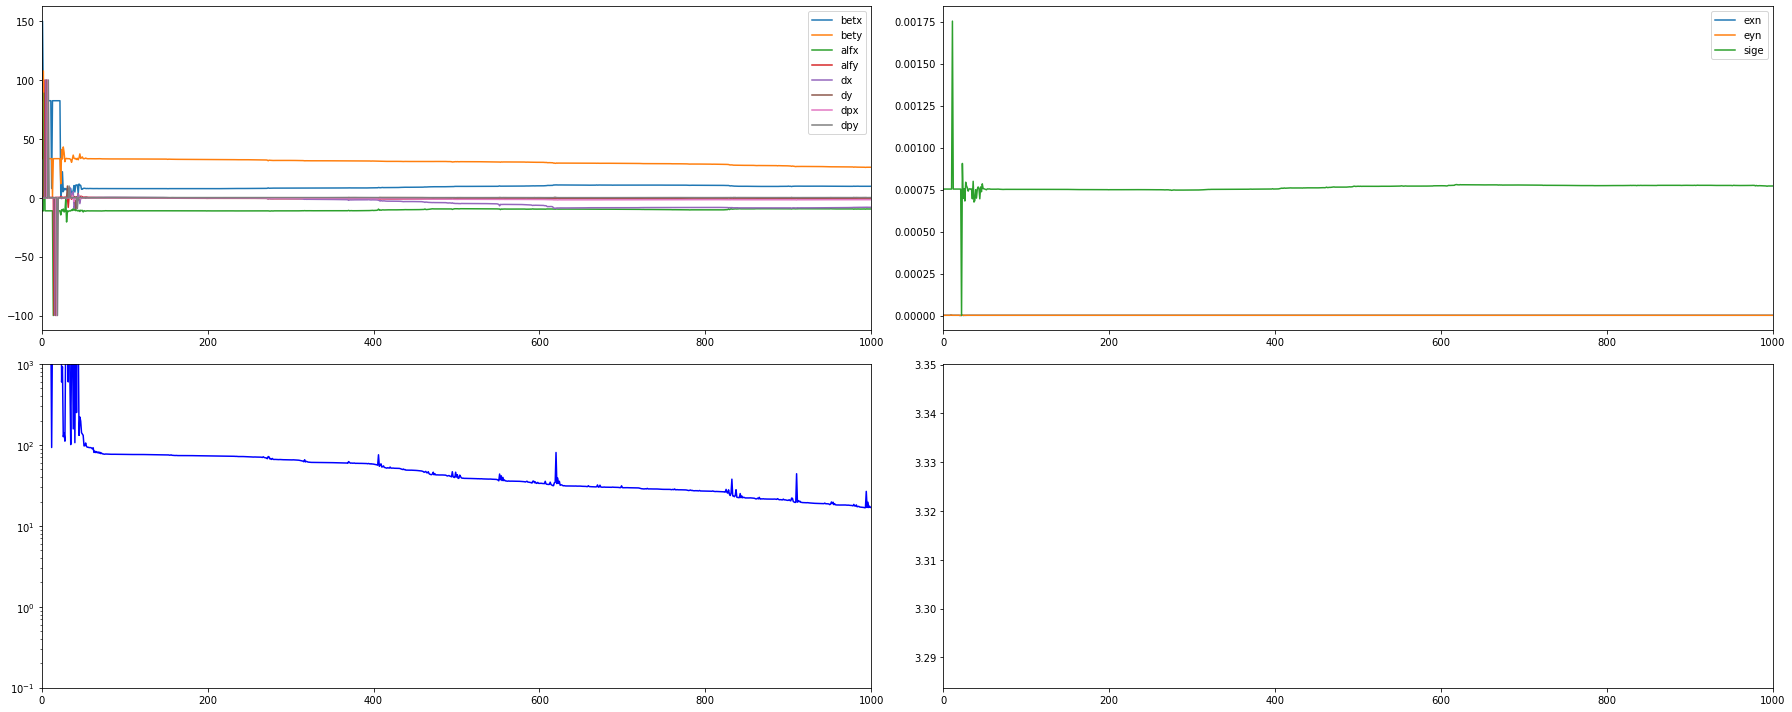

In [2]:
with open('params.pickle', 'rb') as handle:
    params = pickle.load(handle)
    
try:
    with open('filename.pickle', 'rb') as handle:
        objective = pickle.load(handle)
    ax.plot(objective, color="b")

    display.display(pl.gcf())
    display.clear_output(wait=True)
    time.sleep(1.0)
except:
    pass

betx_list = []
bety_list = []
alfx_list = []
alfy_list = []
dx_list = []
dy_list = []
dpx_list = []
dpy_list = []
exn_list = []
eyn_list = []
sige_list = []
for i in range(len(params)):
    betx_list.append((params[i][0]))
    bety_list.append((params[i][1]))
    alfx_list.append((params[i][2]))
    alfy_list.append((params[i][3]))
    dx_list.append((params[i][4]))
    dy_list.append((params[i][5]))
    dpx_list.append((params[i][6]))
    dpy_list.append((params[i][7]))
    exn_list.append((params[i][8]))
    eyn_list.append((params[i][9]))
    sige_list.append((params[i][10]))
    
fig, ax = plt.subplots(2,2, tight_layout=True, figsize=(25,10))
ax[0,0].plot(betx_list, label="betx")
ax[0,0].plot(bety_list, label="bety")
ax[0,0].plot(alfx_list, label="alfx")
ax[0,0].plot(alfy_list, label="alfy")
ax[0,0].plot(dx_list, label="dx")
ax[0,0].plot(dy_list, label="dy")
ax[0,0].plot(dpx_list, label="dpx")
ax[0,0].plot(dpy_list, label="dpy")
ax[0,1].plot(exn_list, label="exn")
ax[0,1].plot(eyn_list, label="eyn")
ax[0,1].plot(sige_list, label="sige")
ax[0,0].set_xlim(0,1000)
ax[0,1].set_xlim(0,1000)
ax[0,0].legend()
ax[0,1].legend()

ax[1,0].plot(objective, color="b")
ax[1,0].set_ylim(1e-1,1e3)
ax[1,0].set_xlim(0,1000)
ax[1,0].set_yscale('log')

ax[1,1].plot(objective, color="b")
ax[1,1].set_ylim(objective[-1]-objective[-1]*0.01, objective[-1]+objective[-1]*0.01)
ax[1,1].set_xlim(0,1000)

In [6]:
# print(params[-1])
# print(objective[-1])

[ 1.09678330e+01  1.77386843e+01 -9.70600166e+00 -9.35742968e-02
 -8.14269198e+00 -2.77864126e-02 -1.68102440e+00  2.02896512e-01
  1.59779895e-06  1.15355285e-06  7.68238732e-04]
3.316950908618862


[ 1.09678330e+01  1.77386843e+01 -9.70600166e+00 -9.35742968e-02
 -8.14269198e+00 -2.77864126e-02 -1.68102440e+00  2.02896512e-01
  1.59779895e-06  1.15355285e-06  7.68238732e-04]
  
3.316950908618862

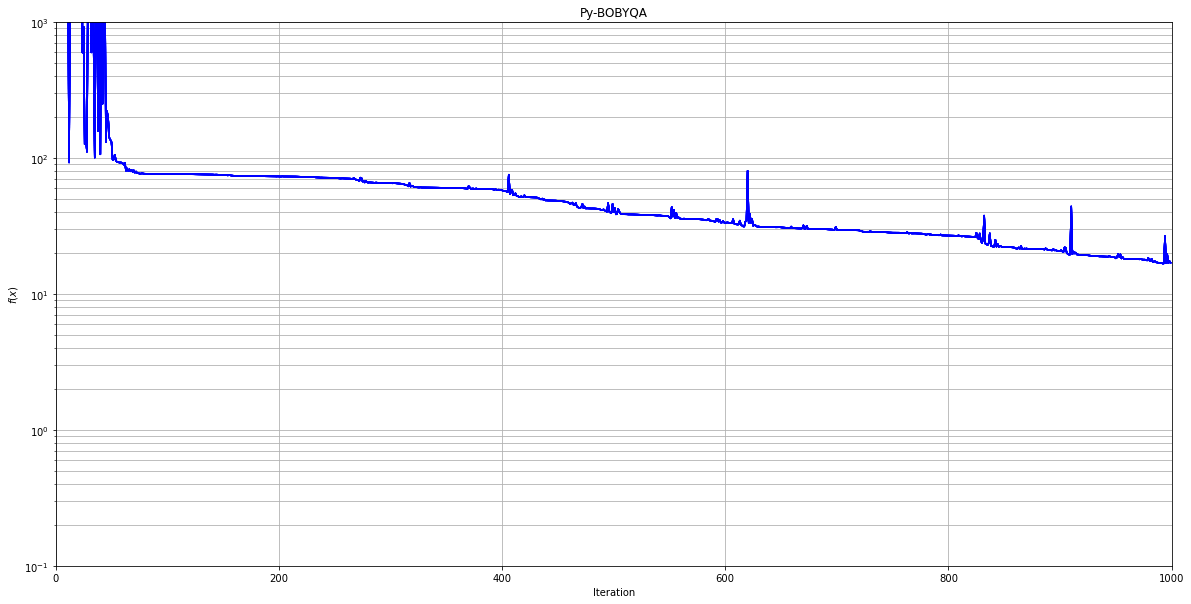

In [56]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(20,10))
ax.set_yscale('log')
ax.set_xlabel("Iteration")
ax.set_ylabel("$f(x)$")
ax.set_title("Py-BOBYQA")
ax.set_ylim(1e-1,1e3)
ax.set_xlim(0,1000)
ax.grid(True, which="both")
# while True:
for i in range(10):
    try:
        with open('filename.pickle', 'rb') as handle:
            objective = pickle.load(handle)
        ax.plot(objective, color="b")
        
        display.display(pl.gcf())
        display.clear_output(wait=True)
        time.sleep(1.0)
    except:
        pass

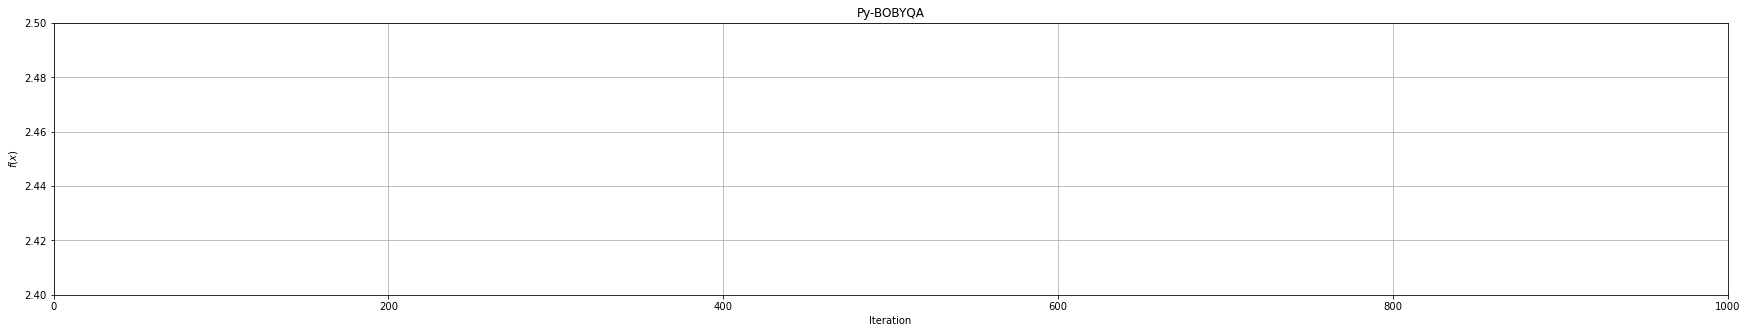

In [27]:
fig, ax = plt.subplots(figsize=(30,5))
ax.set_xlim(0,1000)
ax.set_ylim(2.4,2.5)
with open('filename.pickle', 'rb') as handle:
    objective = pickle.load(handle)
    ax.plot(objective)

ax.set_xlabel("Iteration")
ax.set_ylabel("$f(x)$")
ax.set_title("Py-BOBYQA")
ax.grid(True, which="both")
# plt.savefig("fig/pybobqa.png", facecolor='white', transparent=False, dpi = 300, bbox_inches='tight') 

<IPython.core.display.Javascript object>


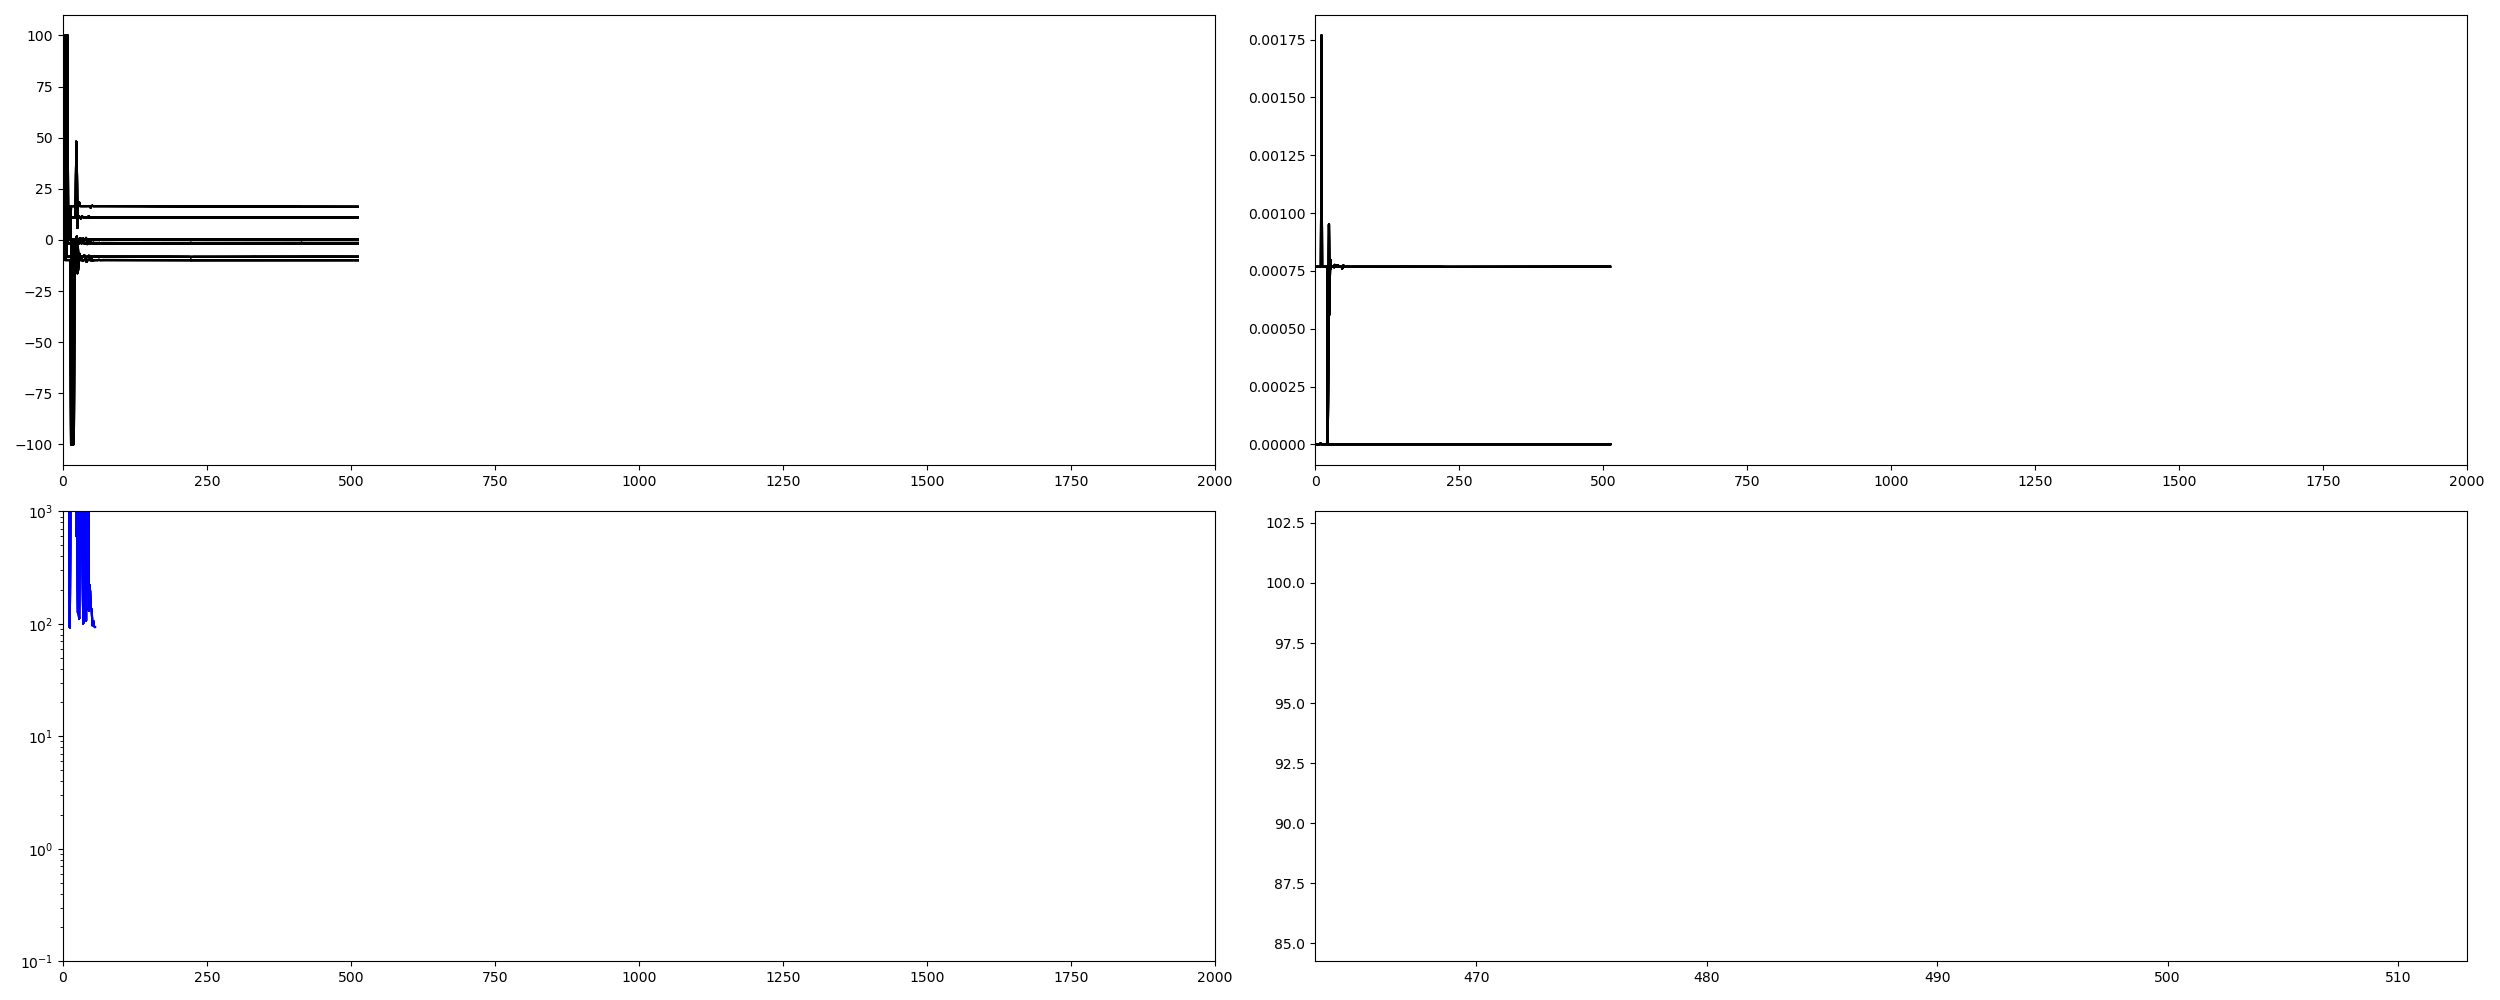

In [55]:
fig, ax = plt.subplots(2,2, tight_layout=True, figsize=(25,10))
for i in range(10):
    try:
        with open('params.pickle', 'rb') as handle:
            params = pickle.load(handle)
    except:
        pass

    try:
        with open('filename.pickle', 'rb') as handle:
            objective = pickle.load(handle)

        display.display(pl.gcf())
        display.clear_output(wait=True)
    except:
        pass

    betx_list = []
    bety_list = []
    alfx_list = []
    alfy_list = []
    dx_list = []
    dy_list = []
    dpx_list = []
    dpy_list = []
    exn_list = []
    eyn_list = []
    sige_list = []
    for i in range(len(params)):
        betx_list.append((params[i][0]))
        bety_list.append((params[i][1]))
        alfx_list.append((params[i][2]))
        alfy_list.append((params[i][3]))
        dx_list.append((params[i][4]))
        dy_list.append((params[i][5]))
        dpx_list.append((params[i][6]))
        dpy_list.append((params[i][7]))
        exn_list.append((params[i][8]))
        eyn_list.append((params[i][9]))
        sige_list.append((params[i][10]))


    ax[0,0].plot(betx_list, label="betx", color="k")
    ax[0,0].plot(bety_list, label="bety", color="k")
    ax[0,0].plot(alfx_list, label="alfx", color="k")
    ax[0,0].plot(alfy_list, label="alfy", color="k")
    ax[0,0].plot(dx_list, label="dx", color="k")
    ax[0,0].plot(dy_list, label="dy", color="k")
    ax[0,0].plot(dpx_list, label="dpx", color="k")
    ax[0,0].plot(dpy_list, label="dpy", color="k")
    ax[0,1].plot(exn_list, label="exn", color="k")
    ax[0,1].plot(eyn_list, label="eyn", color="k")
    ax[0,1].plot(sige_list, label="sige", color="k")
    ax[0,0].set_xlim(0,2000)
    ax[0,1].set_xlim(0,2000)

    ax[1,0].plot(objective, color="b")
    ax[1,0].set_ylim(1e-1,1e3)
    ax[1,0].set_xlim(0,2000)
    ax[1,0].set_yscale('log')

    ax[1,1].plot(objective, color="b")
    ax[1,1].set_ylim(objective[-1]-objective[-1]*0.1, objective[-1]+objective[-1]*0.1)
    try:
        ax[1,1].set_xlim(len(params)-50,len(params))
    except:
        ax[1,1].set_xlim(0, 50)
    
    time.sleep(0.5)

In [11]:
with open('new_df.pickle', 'rb') as handle:
    new_df = pickle.load(handle)
    
with open('df.pickle', 'rb') as handle:
    df = pickle.load(handle)

In [13]:
for i in range(5):
    fig, ax = plt.subplots(1,2, figsize=(25,8))

    display.display(pl.gcf())
    display.clear_output(wait=True)

    with open('params2.pickle', 'rb') as handle:
        params = pickle.load(handle)
    params[-5+i]

    # New initial conditions East Area
    betx0 = params[-1][0]
    bety0 = params[-1][1]
    alfx0 = params[-1][2]
    alfy0 = params[-1][3]
    Dx0 = params[-1][4]
    Dy0 = params[-1][5]
    Dpx0 = params[-1][6]
    Dpy0 = params[-1][7]
    exn = params[-1][8]
    eyn = params[-1][9]
    sige = params[-1][10]

    header_read, twiss_read = read_twiss_file('/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/east-fast-extraction/tfs/fast_extraction.twiss')
    gamma = header_read["gamma"]
    beta = np.sqrt(1-gamma**(-2))



    #################################### Initialize MADX ####################################
    with open('tempfile', 'w') as f:
        madx = Madx(stdout=f,stderr=f)
        madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

    madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
    madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
    madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
    madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")


    ex = exn/(beta*gamma)
    ey = eyn/(beta*gamma)

    madx.command.beam(particle='PROTON',pc="24",exn=exn,eyn=eyn)
    madx.input('BRHO      := BEAM->PC * 3.3356;')

    madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

    madx.input('SEQEDIT, SEQUENCE=f61d;')
    madx.input('FLATTEN;')
    madx.input('REMOVE, ELEMENT=ARBMATRIX;')
    madx.input('FLATTEN;')
    madx.input('ENDEDIT;')

    btv="f61.btv010"


    H_sigma_madx = []
    V_sigma_madx = []
    for idx in list(new_df.index.values):
        k_qfn01 = new_df.k_qfn01[idx]
        k_qdn02 = new_df.k_qdn02[idx]
        k_qfn03 = new_df.k_qfn03[idx]

        madx.input("kQFN1 = "+str(k_qfn01)+";")
        madx.input("kQDN2 = "+str(k_qdn02)+";")
        madx.input("kQFN3 = "+str(k_qfn03)+";")


        madx.use(sequence="f61d")
        twiss_f61d = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()

        H_sigma_madx.append( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )
        V_sigma_madx.append( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )

    # PLOTTING



    df_acq = df[df.Acqu==2].copy()
    ax[0].scatter(df_acq.k_qfn01, df_acq.poptH3_cal, alpha=0.4, s=5, color="slategray", label="Acq 2")
    ax[1].scatter(df_acq.k_qfn01, df_acq.poptV3_cal, alpha=0.4, s=5, color="salmon", label="Acq 2")


    df_acq = df[df.Acqu==3].copy()
    ax[0].scatter(df_acq.k_qfn01, df_acq.poptH3_cal, color="cornflowerblue", s=20, label="Acq 3", zorder=99)
    ax[1].scatter(df_acq.k_qfn01, df_acq.poptV3_cal, color="tomato", s=20, label="Acq 3", zorder=99)

    df_acq = df[df.Acqu==4].copy()
    ax[0].scatter(df_acq.k_qfn01, df_acq.poptH3_cal, color="blue",s=20, label="Acq 4")
    ax[1].scatter(df_acq.k_qfn01, df_acq.poptV3_cal, color="red",s=20, label="Acq 4")

    df_acq = df[df.Acqu==5].copy()
    ax[0].scatter(df_acq.k_qfn01, df_acq.poptH3_cal, alpha=0.4, s=5, color="darkblue", label="Acq 5")
    ax[1].scatter(df_acq.k_qfn01, df_acq.poptV3_cal, alpha=0.4, s=5, color="darkred", label="Acq 5")

    #MAD-X
    ax[0].plot(new_df.k_qfn01, np.array(H_sigma_madx)*1000, color="blue", linewidth=5, zorder=99, label="MAD-X")
    ax[1].plot(new_df.k_qfn01, np.array(V_sigma_madx)*1000, color="red", linewidth=5, zorder=99, label="MAD-X")

#     ax[0].legend()
#     ax[1].legend()

    ax[0].set_xlabel("K QFN01 [A]")
    ax[0].set_ylabel("H beam size $1\sigma$ [mm]")

    ax[1].set_xlabel("K QFN01 [A]")
    ax[1].set_ylabel("V beam size $1\sigma$ [mm]")
    ax[1].set_ylim(1.5, 5)

    # Box with initial parameters
    textstr = '\n'.join((
        "Matched initial parameters:",
        r'$\beta_{x}$='+str(round(betx0,3)),
        r'$\beta_{y}$='+str(round(bety0,3)),
        r'$\alpha_{x}$='+str(round(alfx0,3)),
        r'$\alpha_{y}$='+str(round(alfy0,3)),
        r'$D_{x}$='+str(round(Dx0,3)),
        r'$D_{y}$='+str(round(Dy0,3)),
        r'$D_{px}$='+str(round(Dpx0,3)),
        r'$D_{py}$='+str(round(Dpy0,3)),
        r'$exn$='+str(round(exn,8)),
        r'$eyn$='+str(round(eyn,8)),
        r'$\frac{dp}{p}$='+str(round(sige,6)),
        ))

    props = dict(boxstyle='square', facecolor='white', alpha=1.0)

    # place a text box in upper left in axes coords
    ax[0].text(0.7, 0.75, textstr, transform=ax[0].transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    # fig.suptitle(f"{subset_dirnames}")
    # plt.savefig("fig/quad_scan_filter_pybobqa.png", facecolor='white', transparent=False, dpi = 300, bbox_inches='tight')
    time.sleep(1)

AttributeError: 'DataFrame' object has no attribute 'poptH3_cal'

<IPython.core.display.Javascript object>


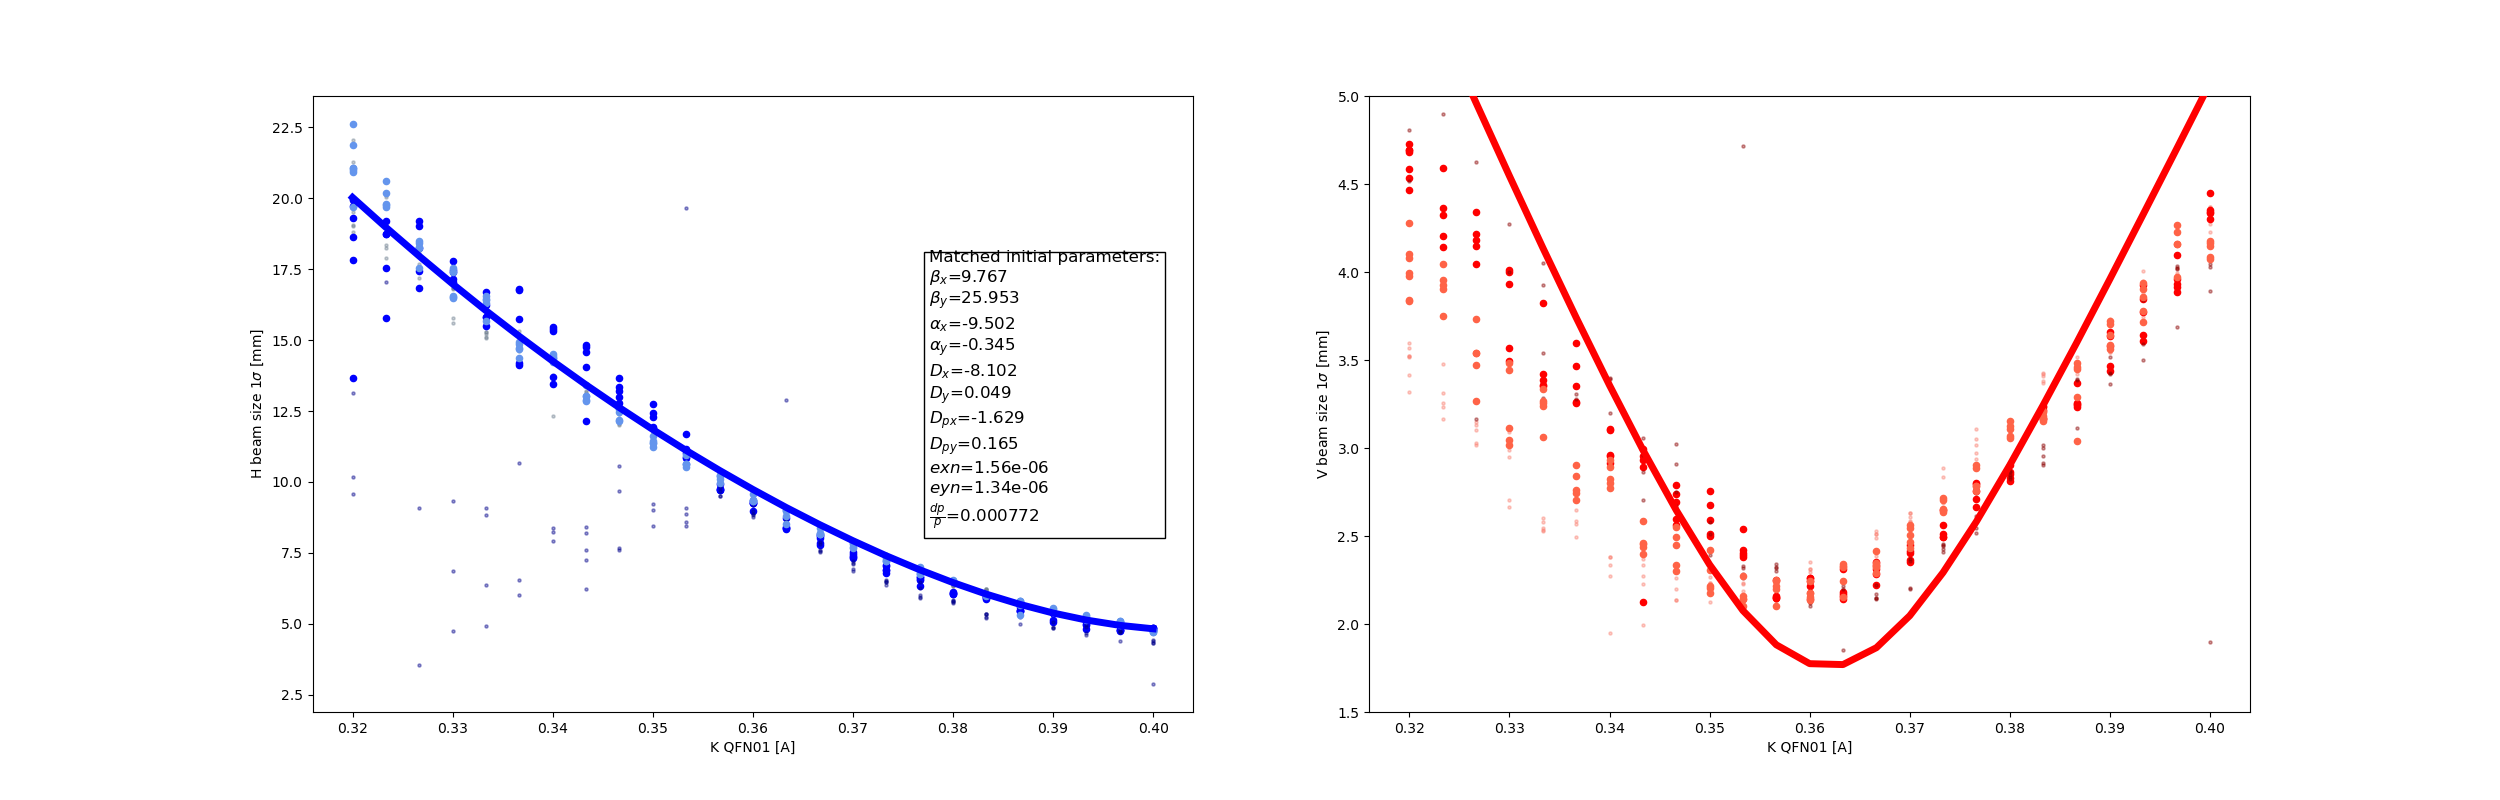

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [6]:
plt.style.use('default')
from matplotlib.animation import FuncAnimation, PillowWriter
%matplotlib notebook
fig, ax = plt.subplots(1,2, figsize=(25,8), tight_layout=False)

frames=100

#################################### Initialize MADX ####################################
with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")
    
def animate(i):

    ax[0].clear()
    ax[1].clear()

    print(i)
    
    try:
            with open('params2.pickle', 'rb') as handle:
                params = pickle.load(handle)

            # New initial conditions East Area
            betx0 = params[10*i][0]
            bety0 = params[10*i][1]
            alfx0 = params[10*i][2]
            alfy0 = params[10*i][3]
            Dx0 = params[10*i][4]
            Dy0 = params[10*i][5]
            Dpx0 = params[10*i][6]
            Dpy0 = params[10*i][7]
            exn = params[10*i][8]
            eyn = params[10*i][9]
            sige = params[10*i][10]

            header_read, twiss_read = read_twiss_file('/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/east-fast-extraction/tfs/fast_extraction.twiss')
            gamma = header_read["gamma"]
            beta = np.sqrt(1-gamma**(-2))

            ex = exn/(beta*gamma)
            ey = eyn/(beta*gamma)

            madx.command.beam(particle='PROTON',pc="24",exn=exn,eyn=eyn)
            madx.input('BRHO      := BEAM->PC * 3.3356;')

            madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

            madx.input('SEQEDIT, SEQUENCE=f61d;')
            madx.input('FLATTEN;')
            madx.input('REMOVE, ELEMENT=ARBMATRIX;')
            madx.input('FLATTEN;')
            madx.input('ENDEDIT;')

            btv="f61.btv010"

            H_sigma_madx = []
            V_sigma_madx = []
            for idx in list(new_df.index.values):
                k_qfn01 = new_df.k_qfn01[idx]
                k_qdn02 = new_df.k_qdn02[idx]
                k_qfn03 = new_df.k_qfn03[idx]

                madx.input("kQFN1 = "+str(k_qfn01)+";")
                madx.input("kQDN2 = "+str(k_qdn02)+";")
                madx.input("kQFN3 = "+str(k_qfn03)+";")


                madx.use(sequence="f61d")
                twiss_f61d = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()

                H_sigma_madx.append( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )
                V_sigma_madx.append( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )

            # PLOTTING
            df_acq = df[df.Acqu==2].copy()
            ax[0].scatter(df_acq.k_qfn01, df_acq.poptH3_cal, alpha=0.4, s=5, color="slategray", label="Acq 2")
            ax[1].scatter(df_acq.k_qfn01, df_acq.poptV3_cal, alpha=0.4, s=5, color="salmon", label="Acq 2")


            df_acq = df[df.Acqu==3].copy()
            ax[0].scatter(df_acq.k_qfn01, df_acq.poptH3_cal, color="cornflowerblue", s=20, label="Acq 3", zorder=99)
            ax[1].scatter(df_acq.k_qfn01, df_acq.poptV3_cal, color="tomato", s=20, label="Acq 3", zorder=99)

            df_acq = df[df.Acqu==4].copy()
            ax[0].scatter(df_acq.k_qfn01, df_acq.poptH3_cal, color="blue",s=20, label="Acq 4")
            ax[1].scatter(df_acq.k_qfn01, df_acq.poptV3_cal, color="red",s=20, label="Acq 4")

            df_acq = df[df.Acqu==5].copy()
            ax[0].scatter(df_acq.k_qfn01, df_acq.poptH3_cal, alpha=0.4, s=5, color="darkblue", label="Acq 5")
            ax[1].scatter(df_acq.k_qfn01, df_acq.poptV3_cal, alpha=0.4, s=5, color="darkred", label="Acq 5")

            #MAD-X
            ax[0].plot(new_df.k_qfn01, np.array(H_sigma_madx)*1000, color="blue", linewidth=5, zorder=99, label="MAD-X")
            ax[1].plot(new_df.k_qfn01, np.array(V_sigma_madx)*1000, color="red", linewidth=5, zorder=99, label="MAD-X")


            ax[0].set_xlabel("K QFN01 [A]")
            ax[0].set_ylabel("H beam size $1\sigma$ [mm]")

            ax[1].set_xlabel("K QFN01 [A]")
            ax[1].set_ylabel("V beam size $1\sigma$ [mm]")
            ax[1].set_ylim(1.5, 5)

            # Box with initial parameters
            textstr = '\n'.join((
                "Matched initial parameters:",
                r'$\beta_{x}$='+str(round(betx0,3)),
                r'$\beta_{y}$='+str(round(bety0,3)),
                r'$\alpha_{x}$='+str(round(alfx0,3)),
                r'$\alpha_{y}$='+str(round(alfy0,3)),
                r'$D_{x}$='+str(round(Dx0,3)),
                r'$D_{y}$='+str(round(Dy0,3)),
                r'$D_{px}$='+str(round(Dpx0,3)),
                r'$D_{py}$='+str(round(Dpy0,3)),
                r'$exn$='+str(round(exn,8)),
                r'$eyn$='+str(round(eyn,8)),
                r'$\frac{dp}{p}$='+str(round(sige,6)),
                ))

            props = dict(boxstyle='square', facecolor='white', alpha=1.0)

            # place a text box in upper left in axes coords
            ax[0].text(0.7, 0.75, textstr, transform=ax[0].transAxes, fontsize=12,
                    verticalalignment='top', bbox=props)
    except:
        print(exception)
        pass
    
    return


ani = FuncAnimation(fig, animate, interval=40, blit=True, repeat=False, frames=frames)
ani.save("gif/pybobqa_progress.gif", dpi=300, writer=PillowWriter(fps=20))